<a href="https://colab.research.google.com/github/ethancpwoo/Practice-NeuralNetwork/blob/main/DogsvCats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 225/225 [00:04<00:00, 51.69it/s]


Test Accuracy:  0.75


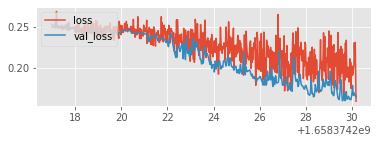

In [9]:
from ast import arg
import os
from re import L
import cv2
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style


REBUILD_DATA = False #set true only once, unless you want to change something in training data
device = torch.device("cuda:0")

class DogsVSCats(): 
    IMG_SIZE = 50
    CATS = "kagglecatsanddogs_5340/PetImages/Cat" #getting images from folders
    DOGS = "kagglecatsanddogs_5340/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1} #1d vector, cats are 0 and dogs r 1
    training_data = [] #array for trainset
    catcount = 0
    dogcount = 0

    def make_training_data(self): #making the training data
        for label in self.LABELS: #for each label, cats and dogs
            for f in tqdm(os.listdir(label)): #go through every single file 
                if "jpg" in f: 
                    try:
                        path = os.path.join(label, f) #join method of cat or dog and jpg. Find path of it
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #read the image from path, then grayscale
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE)) #resize the image 
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) #add to the training_data array both the image and the label
                        if label == self.CATS: 
                            self.catcount += 1
                        elif label == self.DOGS: 
                            self.dogcount += 1
                    except Exception as e: 
                        pass 

        np.random.shuffle(self.training_data) #shuffle the data
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)
    
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data() 

training_data = np.load("training_data.npy", allow_pickle=True) #array
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50) #Convert to tensor and view as 50 by 50 2d tensor for image px by px
X = X/255.0 #idk what this does actually
y = torch.Tensor([i[1] for i in training_data]) #this is whether it is dog or cat (labels)

class Net(nn.Module):
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # 1 image input, 32 output channel, 5*5 kernel/window
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1, 1, 50, 50) #random tensor to pass through nn
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #this value can only be found when we pass an experimental tensor through the neural network
        self.fc2 = nn.Linear(512, 2) #we just flattened here 
    
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) #from first convolutional layer, rectify linear
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2)) #maxpool2d essentially takes essential parts and shrinks them
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2)) #2,2 is the window size

        if self._to_linear is None: 
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] #from the data x, get size of first part of data * by size other dims 
        return x 

    def forward(self, x):
        x = self.convs(x) #run data through convolutional layers run first
        x = x.view(-1, self._to_linear) #flatten data
        x = F.relu(self.fc1(x)) #run data thru linear layers
        x = self.fc2(x) #output layer, no need for activation
        return F.softmax(x, dim = 1)

net = Net().to(device)#make neural network object 
optimizer = optim.Adam(net.parameters(), lr = 0.001) #make optimizer object
loss_function = nn.MSELoss() #make loss function object
MODEL_NAME = f"model-{int(time.time())}" #gives a dynamic model name to make things unique and sorted

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50) #make tensor of pixels training data
X = X/255.0 #i forgot why we did this rewatch
y = torch.Tensor([i[1] for i in training_data]) #make tensor of dog or cat 

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
train_X = X[:-val_size] #simple python splicing of arrays to seperate test and train
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]



def test(size = 32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss


def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)): #for every batch, tqdm shows loading bar
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50) 
                batch_y = train_y[i:i+BATCH_SIZE]
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                #net.zero_grad() #idk what zero gradienting does i forgot
                #outputs = net(batch_X) #put the image through nn
                #matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, batch_y)] #find the mathes between outputs of nn and if it is cat and dog
                #in_sample_acc = matches.count(True)/len(matches) #just counting accuracy 
                #loss = loss_function(outputs, batch_y) #put if it is cat or dog and answer of nn through loss functipon
                #loss.backward() #actually use the loss function
                #optimizer.step() #optimize the nn 

                acc, loss = fwd_pass(batch_X, batch_y, train = True)
                #f.write(f"{MODEL_NAME},{round(time.time(), 3)}, in_sample, {round(float(acc), 2)}, {round(float(loss),4)}")
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(), 3)}, {round(float(acc), 2)}, {round(float(loss),4)}, {round(float(val_acc), 2)}, {round(float(val_loss),4)}\n")


def batch_test(net): 
    BATCH_SIZE = 100
    correct = 0
    total = 0
    with torch.no_grad():
        batch_X = test_X[:BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = test_y[:BATCH_SIZE]

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad()
        outputs = net(batch_X)

        matches = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
        acc = matches.count(True)/len(matches) #same as above
        print("Test Accuracy: ", round(acc, 3))

def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches) #same as above
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

train(net)
batch_test(net)

style.use("ggplot")
model_name = MODEL_NAME

def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")
    times = []
    accuracies = []
    losses = []
    val_accs = []
    val_losses = []
    
    for c in contents: 
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (0,0), sharex = ax1)
    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc = 2)
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc = 2)
    plt.show()

create_acc_loss_graph(model_name)   






        

    
